In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from matplotlib.ticker import FuncFormatter
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import matplotlib.ticker as mticker
import math
import itertools
from typing import Literal
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import time
import joblib
import os
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from functools import partial
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, precision_recall_curve, average_precision_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif, mutual_info_regression

In [2]:
from sklearn import set_config
set_config(transform_output='pandas', display='diagram')

In [3]:
data = pd.read_csv('/kaggle/input/data-for-mining/data_clean.csv')
data = data.drop(columns=['Unnamed: 0'])
data.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40.0,1,0,0,0,0,...,1,0,5,18.0,15.0,1,0,9,4,3
1,0,0,0,0,25.0,1,0,0,1,0,...,0,1,3,0.0,0.0,0,0,7,6,1
2,0,1,1,1,28.0,0,0,0,0,1,...,1,1,5,30.0,30.0,1,0,9,4,8
3,0,1,0,1,27.0,0,0,0,1,1,...,1,0,2,0.0,0.0,0,0,11,3,6
4,0,1,1,1,24.0,0,0,0,1,1,...,1,0,2,3.0,0.0,0,0,11,5,4


In [4]:
# lấy 100000 mẫu dữ liệu phân tầng
X = data.drop(columns=['Diabetes_binary'])
y = data['Diabetes_binary']

X_sampled, _, y_sampled, _ = train_test_split(
    X,
    y,
    train_size=100_000,
    stratify=y,
    random_state=42
)

In [5]:
ordinal_cols = ["GenHlth", "Education", "Income", "AgeGroup"]

continuous_cols = ["BMI", "MentHlth", "PhysHlth"]

binary_columns = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 
                  'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 
                  'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']

target_column = "Diabetes_binary"

In [6]:
# chia tập dữ liệu
X_train, X_val, y_train, y_val = train_test_split(X_sampled, y_sampled, stratify=y_sampled, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

In [7]:
class ConvertAge(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X: pd.Series, y=None):
        return self

    def transform(self, X: pd.Series):
        def map_age_group(age_code):
            if age_code <= 4:
                return "18–39"
            elif age_code <= 7:
                return "40–54"
            elif age_code <= 9:
                return "55–64"
            else:
                return "65+"

        agegroup_map = {
            "18–39": 1,
            "40–54": 2,
            "55–64": 3,
            "65+": 4
        }

        X = X.apply(map_age_group).map(agegroup_map)
        return X.to_frame(name="AgeGroup")

    def get_feature_names_out(self, input_features=None):
        return ["AgeGroup"]

In [8]:
convert_age = ColumnTransformer(
    transformers=
    [
        ("convert_age", ConvertAge(), 'Age'), 
    ],
    remainder='passthrough',
    verbose_feature_names_out=False, # not containing the transformer name in columns of Dataframe
    # force_int_remainder_cols=False
)

# Xây dựng mô hình Machine Learning

In [19]:
class BarPlot:
    def __init__(self, df:pd.DataFrame):
        self.df = df

    @staticmethod
    def readable_numbers(x: float) -> str:
        """
        takes a large number and formats it into K,M to make it more readable

        Args
            x: float value to format

        Returns
            str: formatted string
        """
        if x >= 1e6:
            s = '{:1.2f}M'.format(x*1e-6)
        else:
            s = '{:1.2f}K'.format(x*1e-3)
        return s
    
    def set_locator(self, axes: Axes):
        """
        Format x, y ticklabels into more readable form

        Args
            axes: matplotlib axes to format x, y ticklabels
        """
        def is_number(x):
            x = x.replace('−', '-')
            try:
                float(x)
                return True
            except ValueError:
                return False
    
        x_ticklabels = [tick.get_text() for tick in axes.get_xticklabels()]
        y_ticklabels = [tick.get_text() for tick in axes.get_yticklabels()]
    
        formatter = FuncFormatter(lambda val, pos: self.readable_numbers(val))

        if is_number(x_ticklabels[0]) == True:
            axes.xaxis.set_major_formatter(formatter)
        if is_number(y_ticklabels[0]) == True:
            axes.yaxis.set_major_formatter(formatter)

    def single_plot(
        self,
        x_axis: str,
        y_axis: str,
        hue: str | None,
        kwarg: dict|None = None,
        readable_label: bool = False,
        ax: Axes = None
    ) -> Axes:
        """
        Draw a beautiful and readable bar plot.
    
        Args:
            x_axis: column for x-axis
            y_axis: column for y-axis
            hue: column to group bars (optional)
            readable_label: whether to display readable number labels
            ax: matplotlib axes to draw plot
            kwarg: other keyword arguments (e.g., from seaborn barplot)
        """
    
        # --- Setup Axes ---
        if ax is None:
            ax = plt.gca()
    
        # --- 🌟 Modern aesthetic theme ---
        palette = sns.color_palette("Spectral", n_colors=self.df[hue].nunique()) if hue else "viridis"
        # or: "rocket", "magma", "coolwarm", "crest", "flare", "viridis"

        if kwarg is None:
            kwarg = {}
        # --- Draw the barplot ---
        bar = sns.barplot(
            data=self.df,
            x=x_axis,
            y=y_axis,
            hue=hue,
            ax=ax,
            # palette=palette,
            edgecolor="black",
            linewidth=1.2,
            **kwarg
        )
    
        # --- 🧠 Title & Labels ---
        ax.set_title(
            f'{y_axis} by {x_axis}',
            fontdict={
                'fontsize': 16,
                'fontweight': 'regular',
                # 'fontname': 'Times New Roman'
            },
            pad=15
        )
        ax.set_xlabel(x_axis, fontsize=12, labelpad=10)
        ax.set_ylabel(y_axis, fontsize=12, labelpad=10)
    
        # --- ✨ Ticks & Grid ---
        ax.tick_params(axis='x', labelsize=10, rotation=0)
        ax.tick_params(axis='y', labelsize=10)
        ax.grid(True, axis='y', linestyle='--', alpha=0.3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('gray')
        ax.spines['bottom'].set_color('gray')
    
        # --- 🎨 Legend ---
        if hue is not None:
            ax.legend(
                title=hue,
                title_fontsize=11,
                fontsize=10,
                loc='best',
                frameon=False
            )
    
        # --- 💬 Bar labels ---
        if readable_label:
            for container in bar.containers:
                labels = [p.get_height() for p in container]
                bar.bar_label(
                    container,
                    labels=labels,
                    label_type='edge',
                    fontsize=9,
                    # fontname='Times New Roman',
                    color='black',
                    padding=2
                )
            self.set_locator(bar)
    
        # # --- 🌤️ Tighten layout ---
        # plt.tight_layout()
    
        return bar

    def multiple_plots(self, x_axis_list: list[str], y_axis_list: list[str], hue_list: list[str|None], kwarg: dict,
                       plots_each_row: int, readable_label: bool = False) -> (Figure, np.array([Axes])):
        """
        Draw multiple plots

        Args
            Same as single_plot
            y_axis_list: list of columns for y axis
            plots_each_row: number of plots for each row in matplotlib figure
            kwarg: other keyword arguments if needed.
        """
        
        combination = list(zip(x_axis_list, y_axis_list, hue_list))
        
        length = len(combination)
        number_rows = math.ceil(length / plots_each_row)
    
        fig, axes = plt.subplots(nrows=number_rows, ncols=plots_each_row, figsize=(16, 8),
                                sharey=True)
        
        axes = np.array(axes).reshape(number_rows, plots_each_row)
    
        coordinates = list(itertools.product(range(number_rows), range(plots_each_row)))
    
        for coor, com in zip(coordinates, combination):
            x, y, hue = com
            ax = axes[coor]
            self.single_plot(
                x_axis=x,
                y_axis=y,
                hue=hue,
                readable_label=readable_label,
                kwarg=kwarg,
                ax=ax
            )
    
        # hide any unused axes
        for coor in coordinates[length:]:
            fig.delaxes(axes[coor])

        return fig, axes

In [22]:
# Xây dựng hàm dùng cho stratified k-fold cross validation
class CrossValidation:
    def __init__(self, X:pd.DataFrame, y:pd.Series):
        self.x = X
        self.y = y

    def get_results(self, results:dict, scoring):
        table = {score: [] for score in scoring}
        table['type'] = ['train', 'test']
        for score in scoring:
            for prefix in ['train', 'test']:
                table[score].append(results[f'{prefix}_{score}'].mean().item())

        table = pd.DataFrame(table)
        return table
    
    def stratified_k_fold(self, estimator, n_splits:int, scoring:list[str], kwargs: dict|None=None) -> dict:
        if kwargs is None:
            kwargs = {}

        skf = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)
        results = cross_validate(estimator, self.x, self.y, cv=skf, scoring=scoring, 
                                 return_train_score=True, **kwargs)
        
        table = self.get_results(results, scoring)
        return table

## Performance của mô hình khi chưa được fine-tune

In [11]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
X_val_copy = X_val.copy()

In [25]:
# test hiệu suất trên các mô hình Tree chưa fine-tuned
random_forest = RandomForestClassifier(random_state = 42)
gradien_boost = GradientBoostingClassifier(random_state = 42)
decision_tree = DecisionTreeClassifier(random_state = 42)
xg_boost = XGBClassifier(objective="binary:logistic", random_state=42)
ada_boost = AdaBoostClassifier(random_state=42)

In [13]:
xg_pipeline = Pipeline([
    ("convert_age", convert_age),
    ('xg', xg_boost)
])

rf_pipeline = Pipeline([
    ("convert_age", convert_age),
    ('rf', random_forest)
])

gb_pipeline = Pipeline([
    ("convert_age", convert_age),
    ('gb', gradien_boost)
])

dt_pipeline = Pipeline([
    ("convert_age", convert_age),
    ('dt', decision_tree)
])

ada_pipeline = Pipeline([
    ("convert_age", convert_age),
    ('ada', ada_boost)
])

cross_validator = CrossValidation(X_train_copy, y_train)
scoring = ['f1', 'recall'] # must be list

In [14]:
table_xg_boost = cross_validator.stratified_k_fold(estimator=xg_pipeline, n_splits=3, scoring=scoring,
                                          kwargs=None)

table_random_forest = cross_validator.stratified_k_fold(estimator=rf_pipeline, n_splits=3, scoring=scoring,
                                          kwargs=None)

table_gradien_boost = cross_validator.stratified_k_fold(estimator=gb_pipeline, n_splits=3, scoring=scoring,
                                          kwargs=None)

table_decision_tree = cross_validator.stratified_k_fold(estimator=dt_pipeline, n_splits=3, scoring=scoring,
                                          kwargs=None)

table_ada_boost = cross_validator.stratified_k_fold(estimator=ada_pipeline, n_splits=3, scoring=scoring,
                                          kwargs=None)

In [15]:
combine = pd.concat([table_ada_boost, table_decision_tree, table_random_forest,
                    table_gradien_boost, table_xg_boost], axis=0, ignore_index = True)

combine['model'] = ['Adaboost', 'Adaboost', "Decision Tree", "Decision Tree",
                   'Random Forest', 'Random Forest', 'Gradient Boost', 'Gradient Boost',
                   'XG Boost', 'XG Boost']
combine

,f1,recall,type,model
0,0.282132,0.193114,train,Adaboost
1,0.280205,0.191993,test,Adaboost
2,0.985073,0.971347,train,Decision Tree
3,0.306859,0.324100,test,Decision Tree
4,0.984965,0.973478,train,Random Forest
5,0.226356,0.149041,test,Random Forest
6,0.267047,0.173937,train,Gradient Boost
7,0.253495,0.164742,test,Gradient Boost
8,0.471819,0.329034,train,XG Boost
9,0.259219,0.174499,test,XG Boost


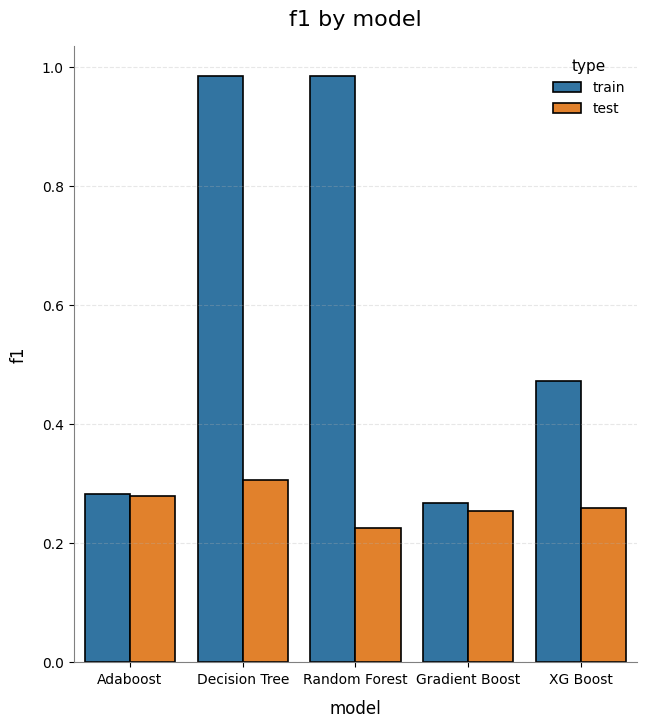

In [16]:
plotter = BarPlot(combine)

x_axis_list = ['model']
y_axis_list = ['f1']
hue_list = ['type']
ig, axes = plotter.multiple_plots(x_axis_list=x_axis_list, y_axis_list=y_axis_list,
                                     hue_list=hue_list, plots_each_row=2, readable_label=False, kwarg={})

# Các mô hình khi chưa được fine-tune đều cho ra điểm số rất thấp và có xu hướng bị overfitting

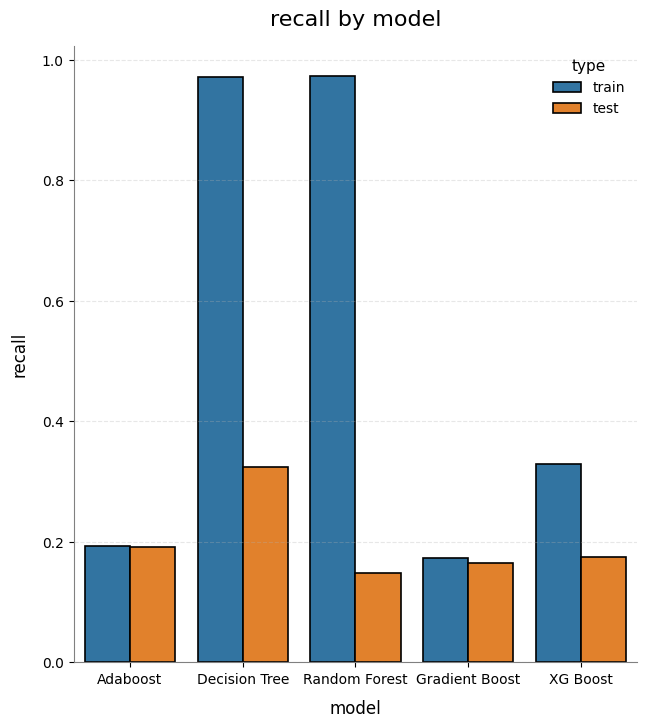

In [17]:
plotter = BarPlot(combine)

x_axis_list = ['model']
y_axis_list = ['recall']
hue_list = ['type']
ig, axes = plotter.multiple_plots(x_axis_list=x_axis_list, y_axis_list=y_axis_list,
                                     hue_list=hue_list, plots_each_row=2, readable_label=False, kwarg={})

# Các mô hình khi chưa được fine-tune đều cho ra điểm số rất thấp và có xu hướng bị overfitting

## Fine-tune và kiểm tra performance của mô hình

In [23]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
X_val_copy = X_val.copy()

In [24]:
# thực hiện fine-tune cho các mô hình ở trên
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit

class GridSearch:
    def __init__(self, X:pd.DataFrame, y:pd.Series):
        self.x = X
        self.y = y

    def get_results(self, cv_results:dict, best_index:np.int64, scoring:dict):

        # Get all the results from the CV and put them in a df
        cv_results = pd.DataFrame(cv_results)
    
        # Isolate the row of the df with the max(mean f1 score)
        best_estimator_results = cv_results.iloc[best_index]
    
        # Extract accuracy, precision, recall, and f1 score from that row        
        table = {score: [] for score in scoring}
        table['type'] = ['train', 'test']
        
        for score in scoring:
            for prefix in ['train', 'test']:
                table[score].append(best_estimator_results[f'mean_{prefix}_{score}'])
                
        # Create table of results
        table = pd.DataFrame(table)
        
        return table
    
    def grid_search_cv(self, estimator, params_grid:dict, scoring:dict, 
                        cv: Literal['KFold', 'StratifiedKFold', 'Predefined'],
                       refit:str, fit_params:dict|None=None):
        
        if cv == 'StratifiedKFold':
            cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
        
        elif cv == 'KFold':
            cv == KFold(n_splits=3, random_state=42, shuffle=True)
        
        elif cv == 'Predefined':
            X_train, X_val, y_train, y_val = train_test_split(self.x, self.y, test_size=0.2, 
                                                          stratify=self.y, random_state=42)
            
            split_index = [0 if x in X_val.index else -1 for x in self.x.index]
            cv = PredefinedSplit(split_index)
        
        search = GridSearchCV(estimator=estimator, param_grid=params_grid, scoring=scoring, 
                              cv=cv, refit=refit, n_jobs=-1, return_train_score=True)
        
        if fit_params is None:
            fit_params = {}
        
        search.fit(self.x, self.y, **fit_params)
        best_index = search.best_index_
        cv_results = search.cv_results_
        
        table = self.get_results(cv_results, best_index, scoring)
        
        best_model = {'best_estimator': search.best_estimator_,
                    'best_params': search.best_params_,}
        
        return best_model, table
    
    def random_search_cv(self, estimator, param_distributions:dict, scoring:dict,
                         cv:Literal['KFold', 'StratifiedKFold', 'Predefined'], 
                         refit:str, fit_params:dict|None=None):
        
        if cv == 'StratifiedKFold':
            cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
        
        elif cv == 'KFold':
            cv = KFold(n_splits=3, random_state=42, shuffle=True)
        
        elif cv == 'Predefined':
            X_train, X_val, y_train, y_val = train_test_split(self.x, self.y, test_size=0.2, 
                                                          stratify=self.y, random_state=42)
            
            split_index = [0 if x in X_val.index else -1 for x in self.x.index]
            cv = PredefinedSplit(split_index)

        search = RandomizedSearchCV(estimator=estimator, param_distributions=param_distributions, 
                                    n_iter=10, n_jobs=-1, return_train_score=True,
                                    scoring=scoring, cv=cv, refit=refit)

        if fit_params is None:
            fit_params = {}
        
        search.fit(self.x, self.y, **fit_params)
        best_index = search.best_index_
        cv_results = search.cv_results_
        
        table = self.get_results(cv_results, best_index, scoring)
        
        best_model = {'best_estimator': search.best_estimator_,
                     'best_params': search.best_params_,
                     }
        
        return best_model, table

In [26]:
xg_pipeline = Pipeline([
    ("convert_age", convert_age),
    ('xg', xg_boost)
])

rf_pipeline = Pipeline([
    ("convert_age", convert_age),
    ('rf', random_forest)
])

gb_pipeline = Pipeline([
    ("convert_age", convert_age),
    ('gb', gradien_boost)
])

dt_pipeline = Pipeline([
    ("convert_age", convert_age),
    ('dt', decision_tree)
])

ada_pipeline = Pipeline([
    ("convert_age", convert_age),
    ('ada', ada_boost)
])

searcher = GridSearch(X = X_train_copy, y = y_train)

In [21]:
# fine tune cho xg boost
param_distributions = {
    "xg__max_depth": np.random.randint(4, 10, 3),
    "xg__learning_rate": [0.05, 0.1, 1],
    "xg__n_estimators": [300, 600],
    "xg__subsample": [0.8, 0.6, 1],
    "xg__colsample_bytree": [0.8],
    "xg__scale_pos_weight": [6.0, 8.0, 10.0]
    
}

scoring = {'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'accuracy': 'accuracy'}

xg_best_model, xg_table = searcher.random_search_cv(estimator=xg_pipeline, param_distributions=param_distributions, 
                                               scoring=scoring, cv='Predefined', refit='f1')

xg_best_model

{'best_estimator': Pipeline(steps=[('convert_age',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('convert_age', ConvertAge(),
                                                   'Age')],
                                    verbose_feature_names_out=False)),
                 ('xg',
                  XGBClassifier(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=0.8, device=None,
                                early_stopping_rounds=None,
                                enable_categorical=False...
                                gamma=None, grow_policy=None,
                                importance_type=None,
                                interaction_constraints=None, learning_rate=0.1,
                                max_bin=None, max_cat_threshold=None,
                                max_cat_t

In [22]:
# fine-tune cho random forest
param_distributions = {'rf__max_depth': [None, 20],
                       'rf__min_samples_leaf': [1, 3, 5, 7],
                       'rf__min_samples_split': [2, 4, 6],
                       'rf__max_features': [2, 4, 6],
                       'rf__n_estimators': [75, 150, 225, 300],
                       'rf__class_weight': [{0: 1, 1: 6}, {0: 1, 1: 8}, {0: 1, 1: 10}]
                      }

scoring = {'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'accuracy': 'accuracy'}

rf_best_model, rf_table = searcher.random_search_cv(estimator=rf_pipeline, param_distributions=param_distributions, 
                                               scoring=scoring, cv='Predefined', refit='f1')
rf_best_model

{'best_estimator': Pipeline(steps=[('convert_age',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('convert_age', ConvertAge(),
                                                   'Age')],
                                    verbose_feature_names_out=False)),
                 ('rf',
                  RandomForestClassifier(class_weight={0: 1, 1: 6}, max_depth=20,
                                         max_features=2, min_samples_leaf=7,
                                         n_estimators=150, random_state=42))]),
 'best_params': {'rf__n_estimators': 150,
  'rf__min_samples_split': 2,
  'rf__min_samples_leaf': 7,
  'rf__max_features': 2,
  'rf__max_depth': 20,
  'rf__class_weight': {0: 1, 1: 6}}}

In [23]:
# fine tune cho gradient boost
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight={0: 1, 1: 8},
    classes=classes,
    y=y_train
)
class_weight_dict = dict(zip(classes, class_weights))
sample_weight = np.array([class_weight_dict[label] for label in y_train])


param_distributions = {'gb__max_depth': np.random.randint(3, 10, 3),
                       'gb__learning_rate': [0.1, 0.01, 1],
                       'gb__min_samples_leaf': [1, 3, 5, 7],
                       'gb__min_samples_split': [2, 4, 6],
                       'gb__n_estimators': [75, 150, 225, 300]}

scoring = {'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'accuracy': 'accuracy'}

fit_params = {"gb__sample_weight": sample_weight}
gb_best_model, gb_table = searcher.random_search_cv(estimator=gb_pipeline, param_distributions=param_distributions, 
                                               scoring=scoring, cv='Predefined', refit='f1', fit_params=fit_params)

gb_best_model

{'best_estimator': Pipeline(steps=[('convert_age',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('convert_age', ConvertAge(),
                                                   'Age')],
                                    verbose_feature_names_out=False)),
                 ('gb',
                  GradientBoostingClassifier(max_depth=np.int64(6),
                                             min_samples_leaf=7,
                                             n_estimators=225,
                                             random_state=42))]),
 'best_params': {'gb__n_estimators': 225,
  'gb__min_samples_split': 2,
  'gb__min_samples_leaf': 7,
  'gb__max_depth': np.int64(6),
  'gb__learning_rate': 0.1}}

In [45]:
# fine tune cho decision tree
param_distributions = {
    "dt__max_depth": [3, 5, 8, None],
    "dt__min_samples_leaf": [1, 10, 50],
    "dt__min_samples_split": [2, 10, 20],
    "dt__max_features": ["sqrt", "log2", None],
    "dt__class_weight": [{0: 1, 1: 6}, {0: 1, 1: 8}, {0: 1, 1: 10}],
}

scoring = {'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'accuracy': 'accuracy'}

dt_best_model, dt_table = searcher.random_search_cv(estimator=dt_pipeline, param_distributions=param_distributions, 
                                               scoring=scoring, cv='Predefined', refit='f1')

dt_best_model

{'best_estimator': Pipeline(steps=[('convert_age',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('convert_age', ConvertAge(),
                                                   'Age')],
                                    verbose_feature_names_out=False)),
                 ('dt',
                  DecisionTreeClassifier(class_weight={0: 1, 1: 10},
                                         min_samples_leaf=50,
                                         min_samples_split=20,
                                         random_state=42))]),
 'best_params': {'dt__min_samples_split': 20,
  'dt__min_samples_leaf': 50,
  'dt__max_features': None,
  'dt__max_depth': None,
  'dt__class_weight': {0: 1, 1: 10}}}

In [25]:
# fine tune cho ada boost
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight={0: 1, 1: 8},
    classes=classes,
    y=y_train
)
class_weight_dict = dict(zip(classes, class_weights))
sample_weight = np.array([class_weight_dict[label] for label in y_train])


param_distributions = {
    "ada__n_estimators": [75, 150, 225, 300],
    "ada__learning_rate": [1.0, 0.5, 0.1, 0.01],
}

scoring = {'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'accuracy': 'accuracy'}

fit_params = {"ada__sample_weight": sample_weight}
ada_best_model, ada_table = searcher.random_search_cv(estimator=ada_pipeline, param_distributions=param_distributions, 
                                               scoring=scoring, cv='Predefined', refit='f1', fit_params=fit_params)

ada_best_model

{'best_estimator': Pipeline(steps=[('convert_age',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('convert_age', ConvertAge(),
                                                   'Age')],
                                    verbose_feature_names_out=False)),
                 ('ada',
                  AdaBoostClassifier(learning_rate=0.5, n_estimators=300,
                                     random_state=42))]),
 'best_params': {'ada__n_estimators': 300, 'ada__learning_rate': 0.5}}

In [26]:
combine = pd.concat([ada_table, dt_table, rf_table, gb_table, xg_table], axis = 0, ignore_index=True)

combine['model'] = ['Adaboost', 'Adaboost', "Decision Tree", "Decision Tree",
                   'Random Forest', 'Random Forest', 'Gradient Boost', 'Gradient Boost',
                   'XG Boost', 'XG Boost']
combine

,f1,recall,precision,accuracy,type,model
0,0.426466,0.827586,0.287243,0.689844,train,Adaboost
1,0.430580,0.824453,0.291378,0.696250,test,Adaboost
2,0.416214,0.800252,0.281245,0.687207,train,Decision Tree
3,0.418069,0.794167,0.283711,0.692031,test,Decision Tree
4,0.529879,0.827166,0.389788,0.795488,train,Random Forest
5,0.457488,0.701626,0.339392,0.768203,test,Random Forest
6,0.495824,0.902860,0.341752,0.744160,train,Gradient Boost
7,0.429639,0.773976,0.297350,0.713750,test,Gradient Boost
8,0.606250,0.909588,0.454635,0.835371,train,XG Boost
9,0.433685,0.645541,0.326525,0.765156,test,XG Boost


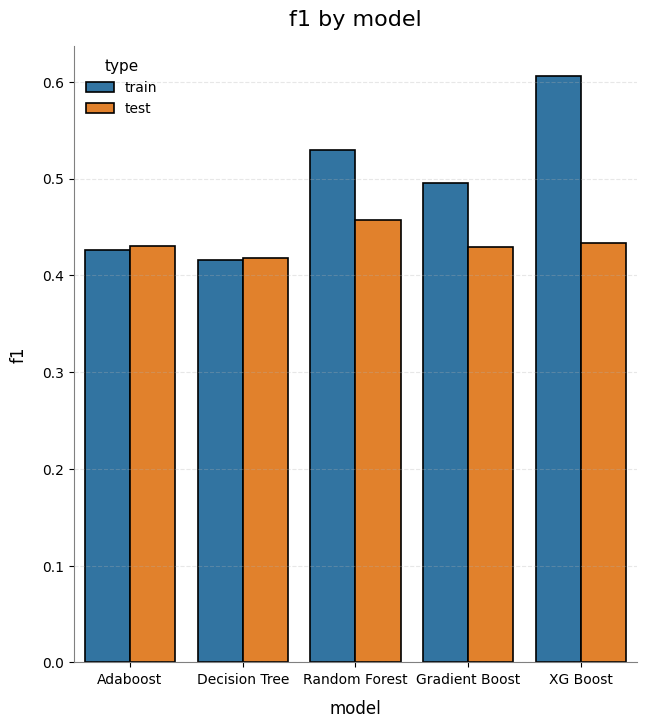

In [27]:
plotter = BarPlot(combine)

x_axis_list = ['model']
y_axis_list = ['f1']
hue_list = ['type']
ig, axes = plotter.multiple_plots(x_axis_list=x_axis_list, y_axis_list=y_axis_list,
                                     hue_list=hue_list, plots_each_row=2, readable_label=False, kwarg={})

# sau khi đã fine tune, ta nhận thấy rằng điểm f1 của các mô hình đã cải thiện đáng kể và đa số
# đều không bị overfitting quá nhiều ngoại trừ XG Boost.
# Nhìn chung thì điểm f1 score tương đối thấp một phần do hạn chế của mô hình và class imbalance

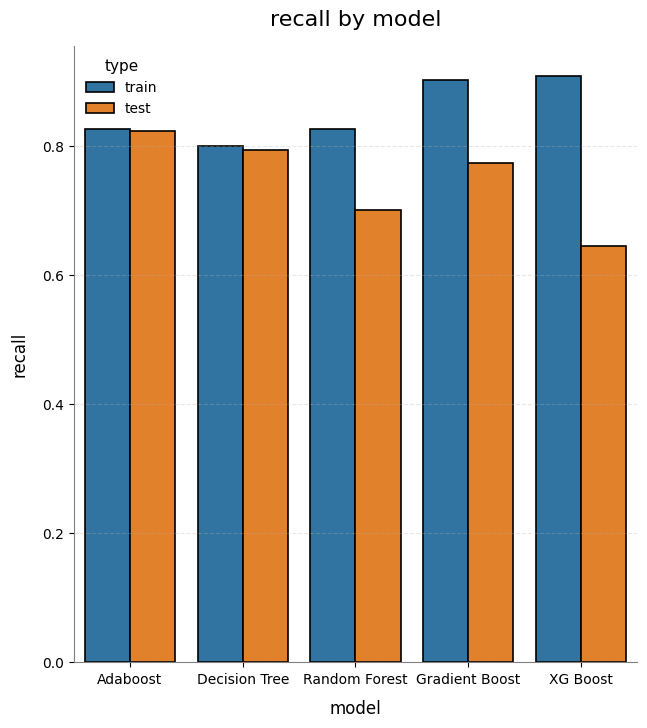

In [28]:
plotter = BarPlot(combine)

x_axis_list = ['model']
y_axis_list = ['recall']
hue_list = ['type']
ig, axes = plotter.multiple_plots(x_axis_list=x_axis_list, y_axis_list=y_axis_list,
                                     hue_list=hue_list, plots_each_row=2, readable_label=False, kwarg={})

# điểm recall của các mô hình cao đáng kể và đa số đều không bị overfitting, đặc biệt là ở ada boost
# mô hình không bị overfitting và cũng là mô hình cho ra điểm recall cao nhất trên tập val với 
# xấp xỉ 0.83 điểm cho cả train và test

# Nhìn chung, điểm recall của các model đều cao, cao nhất đến từ adaboost, việc các mô hình có điểm
# recall cao như vậy đến từ việc ta đã gán trọng số cho lớp thiếu số (minority) để khiến model phải chú ý
# vào việc đoán đúng nhóm thiểu số là nhóm positive. Vì trong bài toán này, recall rất quan trọng

In [27]:
# kiểm tra perfomance của các model trên đối với tập val dataset để chọn ra model tốt nhất
class TestPerformance:
    def __init__(self, X: pd.DataFrame, y:pd.Series):
        self.x = X
        self.y = y

    def model_performance(self, estimators_dict:dict, metrics_fn:dict[str, tuple]={'F1 Score':(f1_score, {})}):
        # Initialize result container
        data = {
            'Model': list(estimators_dict.keys())
        }
    
        # Initialize metric columns
        for metric_name in metrics_fn:
            data[metric_name] = []
    
        # Compute predictions & metrics
        for name, estimator in estimators_dict.items():
            y_pred = estimator.predict(self.x)
    
            for metric_name, (metric_fn, kwargs) in metrics_fn.items():
                score = metric_fn(self.y, y_pred, **kwargs)
                data[metric_name].append(score)
    
        return pd.DataFrame(data)

In [31]:
ada_tuned_model = ada_best_model['best_estimator']

rf_tuned_model = rf_best_model['best_estimator']

gb_tuned_model = gb_best_model['best_estimator']

xg_tuned_model = xg_best_model['best_estimator']

dt_tuned_model = dt_best_model['best_estimator']

In [54]:
tester = TestPerformance(X_val, y_val)

estimators_dict={
    'Ada Boost': ada_tuned_model,
    'Random Forest': rf_tuned_model,
    'Gradient Boost': gb_tuned_model,
    'XG Boost': xg_tuned_model,
    'Decision Tree': dt_tuned_model
}

metrics_fn={
    'F1 Score': (f1_score, {}),
    'Recall': (recall_score, {}),
    'Accuracy': (accuracy_score, {}),
    'Precision': (precision_score, {})
}

data = tester.model_performance(estimators_dict=estimators_dict, metrics_fn=metrics_fn)
data

,Model,F1 Score,Recall,Accuracy,Precision
0,Ada Boost,0.426018,0.829566,0.68850,0.286600
1,Random Forest,0.454795,0.712953,0.76180,0.333893
2,Gradient Boost,0.425800,0.799426,0.69955,0.290180
3,XG Boost,0.436553,0.677072,0.75645,0.322124
4,Decision Tree,0.408786,0.797991,0.67835,0.274771


In [17]:
tester = TestPerformance(X_test, y_test)

estimators_dict={
    'Decision Tree': dt_tuned_model,
}

metrics_fn={
    'F1 Score': (f1_score, {}),
    'Recall': (recall_score, {}),
    'Accuracy': (accuracy_score, {}),
    'Precision': (precision_score, {})
}

data = tester.model_performance(estimators_dict=estimators_dict, metrics_fn=metrics_fn)
data

,Model,F1 Score,Recall,Accuracy,Precision
0,Decision Tree,0.391255,0.851054,0.631062,0.254017


In [51]:
# Nhận thấy mô hình ada boost vẫn cho kết quả tốt trên tập test với điểm recall đạt mức 0.84 là
# ngưỡng mà ta mong muốn cho bài toán này.
# Do đó, ta sẽ lưu lại mô hình đã được train này để sử dụng

best_path = os.path.join('/kaggle/working', 'dt_tuned_pipeline.joblib')
joblib.dump(dt_tuned_model, best_path)

['/kaggle/working/dt_tuned_pipeline.joblib']

# Kiểm tra và diễn giải Mô hình

## Kiểm tra hiệu quả của mô hình

In [11]:
# Để kiểm tra độ hiệu quả, chất lượng của mô hình, ta sẽ dùng Precision-Recall curve và ROC-AUC curve
dt_tuned_model = joblib.load("/kaggle/input/decision-tree-fine-tuned/scikitlearn/default/1/dt_tuned_pipeline.joblib")
dt_tuned_model

/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('convert_age',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('convert_age', ConvertAge(),
                                                  'Age')],
                                   verbose_feature_names_out=False)),
                ('dt',
                 DecisionTreeClassifier(class_weight={0: 1, 1: 10},
                                        min_samples_leaf=50,
                                        min_samples_split=20,
                                        random_state=42))])

In [31]:
class PrecisionRecallCurve:
    def __init__(self, X:pd.DataFrame, y:pd.Series):
        self.x = X
        self.y = y

    def compute_average_precision_score(self, estimators_dict:dict, tree_models:bool):
        estimators_score = {}
        for estimator_name, estimator in estimators_dict.items():
            y_score = estimator.predict_proba(self.x)[:, 1] # certainty measure for the positive class (class 1)
            ap_score = average_precision_score(self.y, y_score)
            estimators_score[estimator_name] = ap_score
        return estimators_score
    
    def plot_precision_recall_curve(self, estimators_dict:dict, plots_each_row:int, tree_models:bool):
        num_plots = len(estimators_dict)
        number_rows = math.ceil(num_plots / plots_each_row)
        
        fig, axes = plt.subplots(nrows=number_rows, ncols=plots_each_row, figsize=(16, 8),) # sharey=True
        axes = np.array(axes).reshape(number_rows, plots_each_row)
        coordinates = list(itertools.product(range(number_rows), range(plots_each_row)))
        
        for coor, (estimator_name, estimator) in zip(coordinates, estimators_dict.items()):
            y_score = estimator.predict_proba(self.x)[:, 1] # certainty measure for the positive class (class 1)
            precision, recall, thresholds = precision_recall_curve(self.y, y_score)
            close_zero = np.argmin(np.abs(thresholds - 0.5))
            
            axes[coor].plot(precision, recall, label=estimator_name)
            axes[coor].plot(precision[close_zero], recall[close_zero], 'o', markersize=4, label=f"{estimator_name} default threshold", fillstyle="none", c='k', mew=2)
            axes[coor].set_xlabel("Precision")
            axes[coor].set_ylabel("Recall")
            axes[coor].legend(loc="best")
            axes[coor].set_ylim([0, 1])
            axes[coor].grid()

        # hide any unused axes
        for coor in coordinates[num_plots:]:
            fig.delaxes(axes[coor])

    def plot_precision_recall_with_thresholds(self, estimators_dict:dict, plots_each_row:int, tree_models:bool):
        num_plots = len(estimators_dict)
        number_rows = math.ceil(num_plots / plots_each_row)
        
        fig, axes = plt.subplots(nrows=number_rows, ncols=plots_each_row, figsize=(16, 8),) # sharey=True
        axes = np.array(axes).reshape(number_rows, plots_each_row)
        coordinates = list(itertools.product(range(number_rows), range(plots_each_row)))

        for coor, (estimator_name, estimator) in zip(coordinates, estimators_dict.items()):
            y_score = estimator.predict_proba(self.x)[:, 1] # certainty measure for the positive class (class 1)
            precision, recall, thresholds = precision_recall_curve(self.y, y_score)

            axes[coor].axvline(x=0.5, color="red", linestyle=":", linewidth=2, label=f"{estimator_name}'s Default Threshold")
            axes[coor].plot(thresholds, precision[:-1], "b--", label="Precision")
            axes[coor].plot(thresholds, recall[:-1], "g-", label="Recall")
            axes[coor].set_xlabel("Threshold")
            axes[coor].set_title(estimator_name)
            axes[coor].legend(loc="best")
            axes[coor].set_ylim([0, 1])
            axes[coor].grid()

        # hide any unused axes
        for coor in coordinates[num_plots:]:
            fig.delaxes(axes[coor])

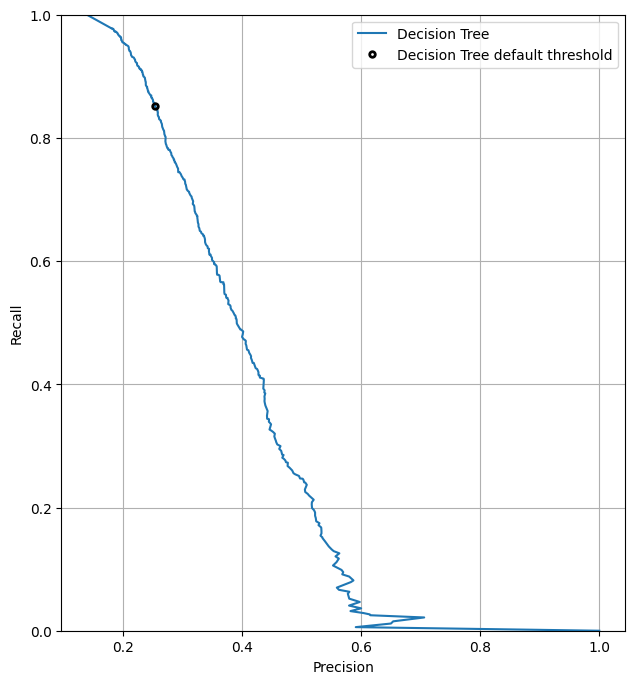

In [32]:
precision_recall = PrecisionRecallCurve(X_test, y_test)

estimators_dict={
    'Decision Tree': dt_tuned_model
}
plots_each_row=2
tree_models=True

precision_recall.plot_precision_recall_curve(estimators_dict, plots_each_row, tree_models)

# Từ biểu đồ Precision-Recall có thể nhận thấy một sự đánh đổi đáng kể giữa recall và precision
# khi recall càng tăng thì precision có xu hướng sẽ giảm xuống
# Nhìn vào đường này, ta thấy được đường Precision-Recall khá dốc, đồng nghĩa với mô hình không
# thật sự học tốt trên tập dữ liệu khi chỉ cần cố gắng tăng điểm Recall thì Precision sẽ giảm đi đáng kể

In [33]:
# Tính điểm cho phần diện tích nằm dưới đường cong PR ở trên
estimators_dict={
    'Decision Tree': dt_tuned_model
}
tree_models=True

scores = precision_recall.compute_average_precision_score(estimators_dict, tree_models)
print(f"Điểm Average Precision của Decision Tree là: {scores['Decision Tree']}")

# Dựa vào điểm số này ta nhận thấy mô hình đã train học không thật sự tốt và chưa đủ chất lượng
# khi có điểm AP thấp, điều này được lí giải là bởi mô hình chú trọng vào việc tăng điểm recall
# nhưng điều này làm giảm điểm presicion đi -> điểm AP sẽ thấp

Điểm Average Precision của Decision Tree là: 0.39289870801199417


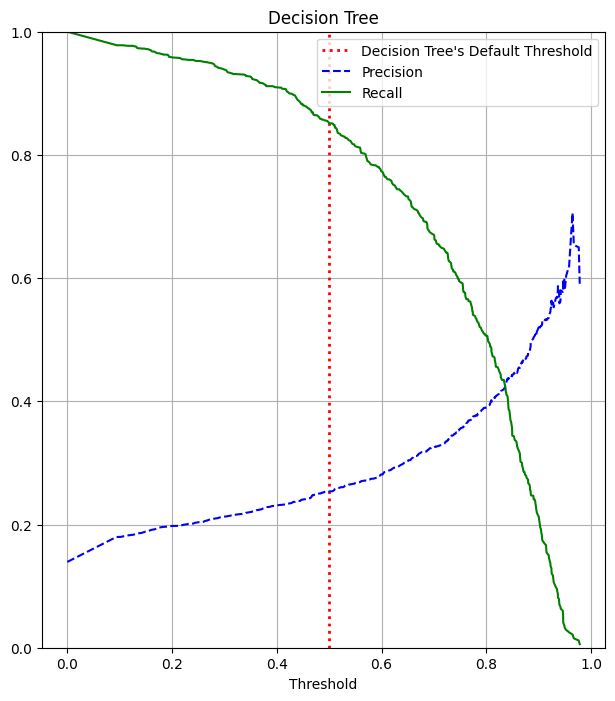

In [34]:
estimators_dict={
    'Decision Tree': dt_tuned_model
}
plots_each_row=2
tree_models=True

precision_recall.plot_precision_recall_with_thresholds(estimators_dict, plots_each_row, tree_models)
# Tại threshold là xấp xỉ 0.82 thì precision và recall ngang nhau đối với Decision Tree

In [52]:
# Tiếp theo ta sẽ đến với đường cong ROC (Receiver operating characteristic)
class ROCCurve:
    def __init__(self, X:pd.DataFrame, y:pd.Series):
        self.x = X
        self.y = y

    def plot_roc_curve_with_thresholds(self, estimators_dict:dict, plots_each_row:int, tree_models:bool):
        num_plots = len(estimators_dict)
        number_rows = math.ceil(num_plots / plots_each_row)
        
        fig, axes = plt.subplots(nrows=number_rows, ncols=plots_each_row, figsize=(16, 8),) # sharey=True
        axes = np.array(axes).reshape(number_rows, plots_each_row)
        coordinates = list(itertools.product(range(number_rows), range(plots_each_row)))

        for coor, (estimator_name, estimator) in zip(coordinates, estimators_dict.items()):
            y_score = estimator.predict_proba(self.x)[:, 1] # certainty measure for the positive class (class 1)
            fpr, tpr, thresholds = roc_curve(self.y, y_score)

            axes[coor].axvline(x=0.5, color="red", linestyle=":", linewidth=2, label=f"{estimator_name}'s Default Threshold")
            axes[coor].plot(thresholds, fpr, "b--", label="FPR")
            axes[coor].plot(thresholds, tpr, "g-", label="TPR (recall)")
            axes[coor].set_xlabel("Threshold")
            axes[coor].set_title(estimator_name)
            axes[coor].legend(loc="best")
            axes[coor].set_ylim([0, 1])
            axes[coor].grid()

        # hide any unused axes
        for coor in coordinates[num_plots:]:
            fig.delaxes(axes[coor])
    
    def plot_roc_curve(self, estimators_dict:dict, plots_each_row:int, tree_models:bool):
        num_plots = len(estimators_dict)
        number_rows = math.ceil(num_plots / plots_each_row)
        
        fig, axes = plt.subplots(nrows=number_rows, ncols=plots_each_row, figsize=(16, 8),) # sharey=True
        axes = np.array(axes).reshape(number_rows, plots_each_row)
        coordinates = list(itertools.product(range(number_rows), range(plots_each_row)))

        for coor, (estimator_name, estimator) in zip(coordinates, estimators_dict.items()):
            y_score = estimator.predict_proba(self.x)[:, 1]
            fpr, tpr, thresholds = roc_curve(self.y, y_score)
            close_zero = np.argmin(np.abs(thresholds - 0.5))
            
            axes[coor].plot(fpr, tpr, label=f"{estimator_name}'s ROC Curve")
            axes[coor].set_xlabel("FPR")
            axes[coor].set_ylabel("TPR (recall)")
            axes[coor].plot(fpr[close_zero + 1], tpr[close_zero + 1], 'o', markersize=4, label=f"{estimator_name} default threshold", fillstyle="none", c='k', mew=2)
            axes[coor].plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), "b--", label=f"Random Classifier")
            axes[coor].legend(loc='best')
            axes[coor].grid()

        # hide any unused axes
        for coor in coordinates[num_plots:]:
            fig.delaxes(axes[coor])

    def compute_auc_score(self, estimators_dict:dict, tree_models:bool):
        estimators_score = {}
        for estimator_name, estimator in estimators_dict.items():
            y_score = estimator.predict_proba(self.x)[:, 1] # certainty measure for the positive class (class 1)
            auc_score = roc_auc_score(self.y, y_score)
            estimators_score[estimator_name] = auc_score
        return estimators_score

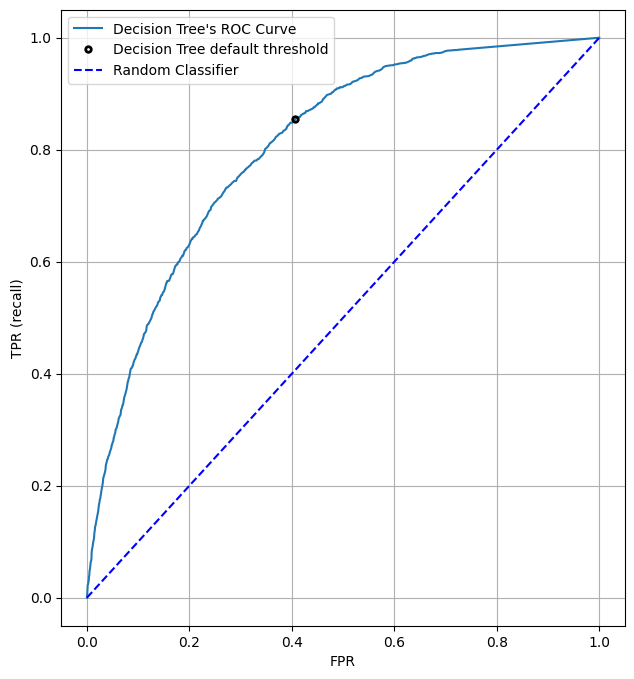

In [53]:
roc_curve_plotter = ROCCurve(X_test, y_test)

estimators_dict={
    'Decision Tree': dt_tuned_model
}
tree_models=True
plots_each_row=2

roc_curve_plotter.plot_roc_curve(estimators_dict, plots_each_row, tree_models)

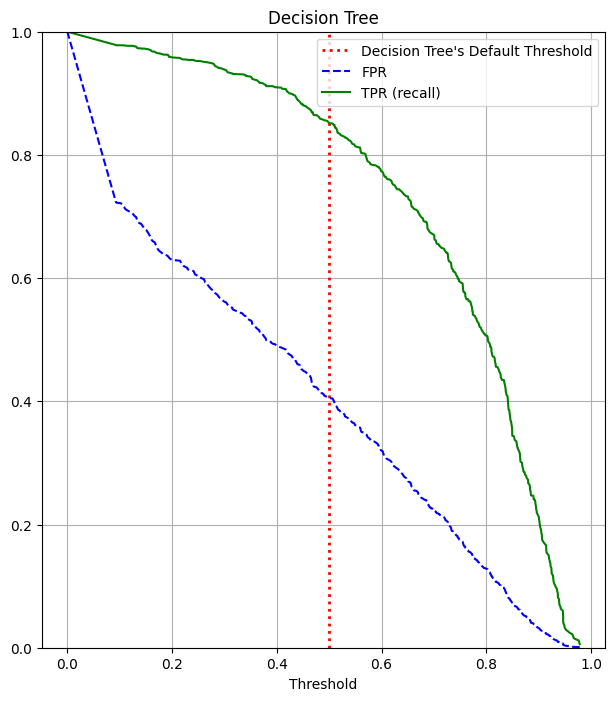

In [50]:
estimators_dict={
    'Decision Tree': dt_tuned_model
}
tree_models=True
plots_each_row=2

roc_curve_plotter.plot_roc_curve_with_thresholds(estimators_dict, plots_each_row, tree_models)

In [51]:
estimators_dict={
    'Decision Tree': dt_tuned_model
}
tree_models=True

score = roc_curve_plotter.compute_auc_score(estimators_dict, tree_models)
print(f"Điểm AUC của Decision Tree là: {score['Decision Tree']}")

# Điểm AUC cao -> mô hình rất tốt trong việc dự đoán positive đối với những người thật sự là positive
# cũng như ít nhầm lẫn trong việc dự đoán positive đối với những người thật sự là negative

Điểm AUC của Decision Tree là: 0.805547554941091


## Diễn giải mô hình

In [33]:
# Kiểm tra những đặc trưng mà Ada Boost cho là quan trọng
def plot_feature_importances(estimators_dict:dict, plots_each_row:int):
    num_plots = len(estimators_dict)
    number_rows = math.ceil(num_plots / plots_each_row)
        
    fig, axes = plt.subplots(nrows=number_rows, ncols=plots_each_row, figsize=(16, 8),) # sharey=True
    axes = np.array(axes).reshape(number_rows, plots_each_row)
    coordinates = list(itertools.product(range(number_rows), range(plots_each_row)))
    
    for coor, (estimator_name, estimator) in zip(coordinates, estimators_dict.items()):
        series = pd.Series(
            data = estimator.feature_importances_,
            index = estimator.feature_names_in_
        )
        n_features = series.shape[0]
        colors = plt.cm.tab20(np.linspace(0, 1, n_features))
        
        bars = axes[coor].barh(range(n_features), series.values, align='center', color=colors, edgecolor="black")
        axes[coor].set_yticks(np.arange(n_features), series.index, fontsize=10)
        
        axes[coor].set_xlabel("Feature importance", fontsize=12, weight='bold')
        axes[coor].set_ylabel("Feature", fontsize=12, weight='bold')
        axes[coor].set_title(estimator_name, fontsize=14, weight='bold')

        # Add gridlines for better contrast
        axes[coor].grid(axis='x', linestyle='--', alpha=0.6)
    
        # Add value labels on bars
        for bar in bars:
            axes[coor].text(bar.get_width() + 0.002, 
                     bar.get_y() + bar.get_height()/2, 
                     f"{bar.get_width():.3f}",
                     va='center', fontsize=9, color='black')

    # hide any unused axes
    for coor in coordinates[num_plots:]:
        fig.delaxes(axes[coor])

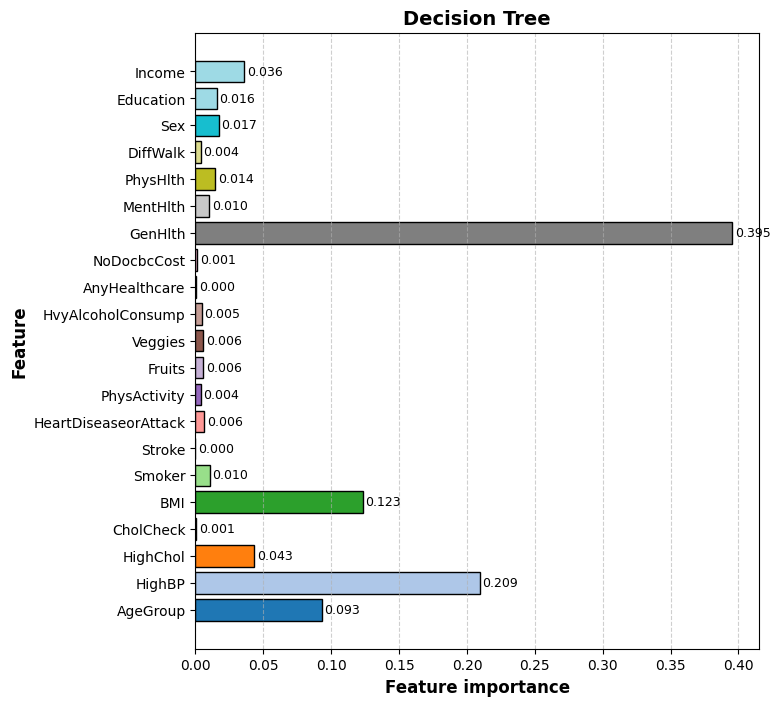

In [13]:
dt_ = dt_tuned_model[-1]

estimators_dict={
    'Decision Tree': dt_,
}
plots_each_row=2

plot_feature_importances(estimators_dict, plots_each_row)

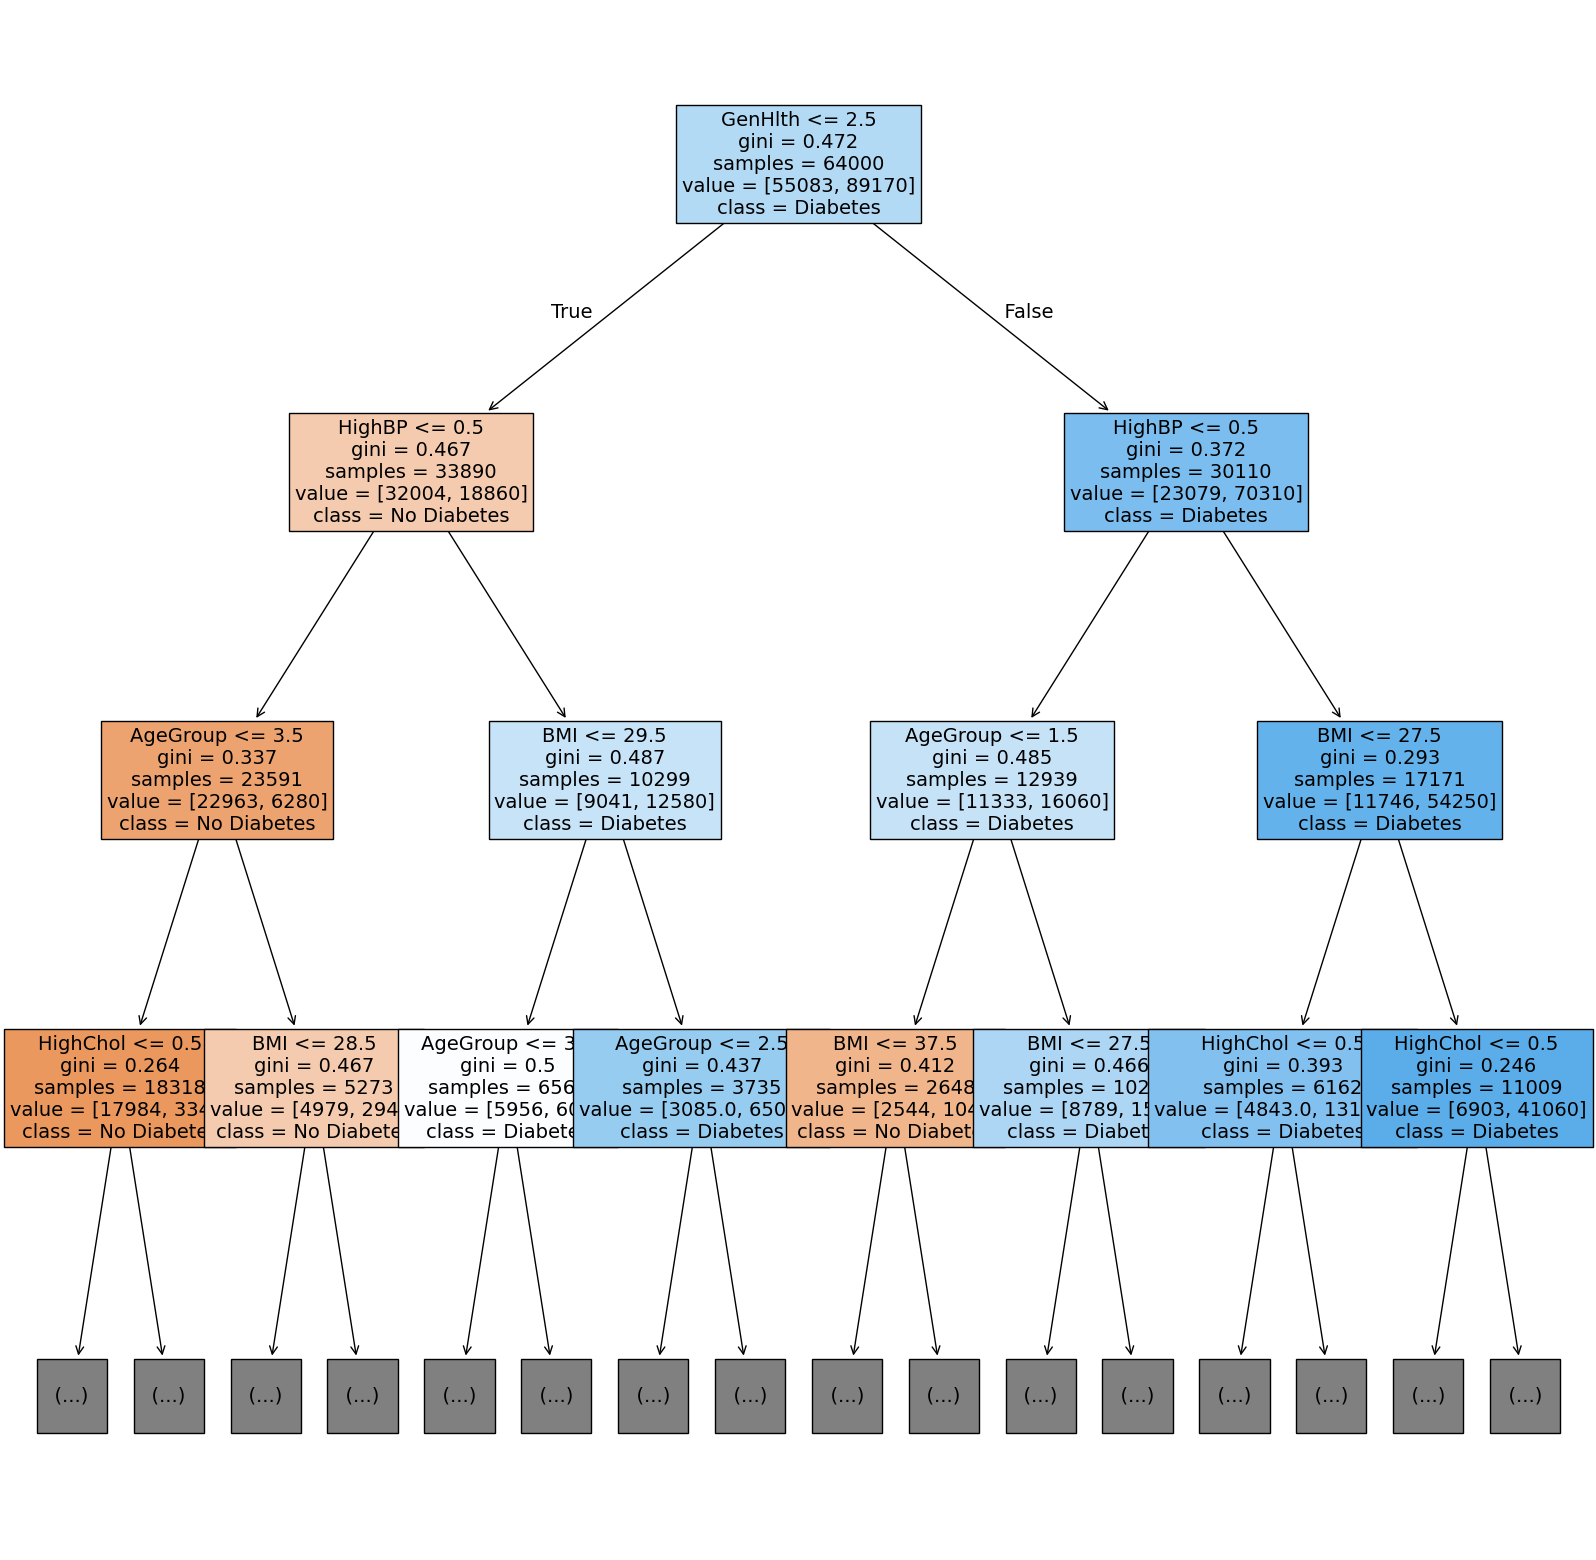

In [22]:
# Ming hoạ cách một cây trong Ada Boost đưa ra quyết định
plt.figure(figsize=(20,20))
dt_ = dt_tuned_model[-1]
plot_tree(dt_, max_depth=3, fontsize=14, feature_names=dt_.feature_names_in_, 
          class_names={0:'No Diabetes', 1:'Diabetes'}, filled=True, impurity=True)

plt.show()